# Evaluating the calibration of a DL model


## Setup: import libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

## Data loading

The dataset we use is a well-known toy multiclass dataset concerning wine quality: https://archive.ics.uci.edu/ml/datasets/wine+Quality

We preprocess the original quality index into three classes (low, medium, and high quality), similarly to this notebook that you can check for more information about the dataset: https://www.kaggle.com/code/mgmarques/wines-type-and-quality-classification-exercises

In [ ]:
!wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [ ]:
def load_data():
  """ Load and preprocesses the wine dataset.
  Returns:
    - X_train, X_test, y_train, y_test [tf.Tensor]: train and test input/output matrices.
  """
  import pandas as pd
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler, MinMaxScaler
  
  data = pd.read_csv('winequality-white.csv', sep=';')
  data['quality_label'] = data.quality.apply(lambda q: 0 if q <= 5 else 1 if q <= 7 else 2)
  data = data.dropna() # Remove NAs
  del data['quality']  # Drop the original label
  X, y = data.values[:, :-1], data.values[:, -1]
  X = StandardScaler().fit_transform(X) # Normalize (we are "cheating" by also using the test data)
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1234)
  return tf.constant(X_train), tf.constant(y_train), tf.constant(X_test), tf.constant(y_test)

In [ ]:
X_train, y_train, X_test, y_test = load_data()

In [ ]:
# Check some details about the dataset. You are free to add any additional pre-processing to understand it better.
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Number of classes: {tf.reduce_max(y_train) + 1}')

Shape of X_train: (3673, 11)
Shape of y_train: (3673,)
Number of classes: 3.0


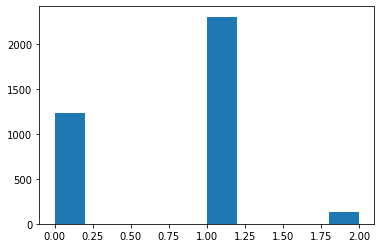

In [ ]:
# This is highly unbalanced by default
_ = plt.hist(y_train)

In [ ]:
# Baseline accuracy
from sklearn.dummy import DummyClassifier
DummyClassifier().fit(X_train, y_train).score(X_test, y_test)

0.6285714285714286

### Train a neural network model 


Here I create using Tensorflow API a small neural networks for classification.

In [ ]:
# Set seed for reproducibility
tf.keras.utils.set_random_seed(1234)
tf.random.set_seed(1234)

# Compute the number of classes
num_classes = tf.reduce_max(y_train) + 1

# Neural Network: 
net = tf.keras.Sequential()
# first layer 
net.add(tf.keras.layers.Dense(150))
net.add(tf.keras.layers.BatchNormalization())
net.add(tf.keras.layers.Activation('relu'))
# second layer
net.add(tf.keras.layers.Dense(150))
net.add(tf.keras.layers.BatchNormalization())
net.add(tf.keras.layers.Activation('relu'))
# ouput layer (logit)
net.add(tf.keras.layers.Dense(num_classes))

In [ ]:
# Set seed for reproducibility
tf.keras.utils.set_random_seed(1234)
tf.random.set_seed(1234)

# initialize loss
cross_entropy_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# initialize metric
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
# initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

net.compile(optimizer=optimizer, loss=cross_entropy_loss, metrics=accuracy)
 
 # train
history = net.fit(
    x=X_train,
    y=y_train,
    batch_size=128,
    epochs=100,
    verbose=1)

Epoch 1/100
29/29 [==============================] - 2s 5ms/step - loss: 0.7809 - sparse_categorical_accuracy: 0.6725
Epoch 2/100
29/29 [==============================] - 0s 12ms/step - loss: 0.6054 - sparse_categorical_accuracy: 0.7373
Epoch 3/100
29/29 [==============================] - 0s 12ms/step - loss: 0.5785 - sparse_categorical_accuracy: 0.7487
Epoch 4/100
29/29 [==============================] - 0s 10ms/step - loss: 0.5617 - sparse_categorical_accuracy: 0.7542
Epoch 5/100
29/29 [==============================] - 0s 11ms/step - loss: 0.5525 - sparse_categorical_accuracy: 0.7626
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.5348 - sparse_categorical_accuracy: 0.7691
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.5191 - sparse_categorical_accuracy: 0.7767
Epoch 8/100
29/29 [==============================] - 0s 5ms/step - loss: 0.5190 - sparse_categorical_accuracy: 0.7754
Epoch 9/100
29/29 [==============================] -

In [ ]:
# Evaluate the neural network on the test dataset
_ , acc = net.evaluate(X_test, y_test, verbose = 0)
# print the accuracy
print("The accuracy on test is: {:0.1f}%".format(acc * 100)) # we can see that the model overfit a bit

The accuracy on test is: 75.7%


### Confidence histogram of the network 

Reference: [On the calibration of modern neural networks](https://arxiv.org/abs/1706.

In [ ]:
# To start: this is the number of bins for the histogram and the corresponding values. You are free to modify the number of bins.
num_bins = 10
bins = tf.linspace(start=0.0, stop=1.0, num=num_bins)
print(bins)

tf.Tensor(
[0.         0.11111111 0.22222222 0.33333334 0.44444445 0.5555556
 0.6666667  0.7777778  0.8888889  1.        ], shape=(10,), dtype=float32)


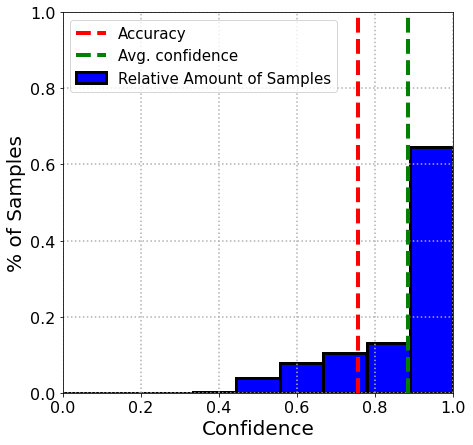

In [ ]:
# compute the prediction logit (shape = (N, K))
y_pred = net.predict(X_test, verbose = 0)

# get the confidence for all the sample (highest output probability)
confidence = tf.reduce_max(tf.nn.softmax(logits = y_pred), axis = 1)
avg_conf = tf.reduce_mean(confidence)

# Plot parameters 
params_dict = {"figure.figsize": (7,7),
              "axes.titlesize" : 24,
              "axes.labelsize" : 20,
              "lines.linewidth" : 4,
              "lines.markersize" : 10,
              "xtick.labelsize" : 16,
              "ytick.labelsize" : 16}

# confidence histogram
with plt.rc_context(params_dict):
  plt.axis([0., 1., 0., 1.])
  bin_width = bins[1]-bins[0]
  weights = tf.ones_like(confidence)/float(len(confidence))
  plt.hist(x = confidence, bins = bins, weights = weights,  width = bin_width, 
          color = "blue", edgecolor = "black", linewidth = 3, label = "Relative Amount of Samples")
  plt.axvline(x = acc, linestyle = "--", color = "red", label = "Accuracy")
  plt.axvline(x = avg_conf, linestyle = "--", color = "green", label = "Avg. confidence")
  
  plt.grid(linestyle=':', linewidth=1.5)
  plt.ylabel("% of Samples")
  plt.xlabel("Confidence")
  plt.legend(fontsize = 15)
  plt.show();

### Reliability diagrams 



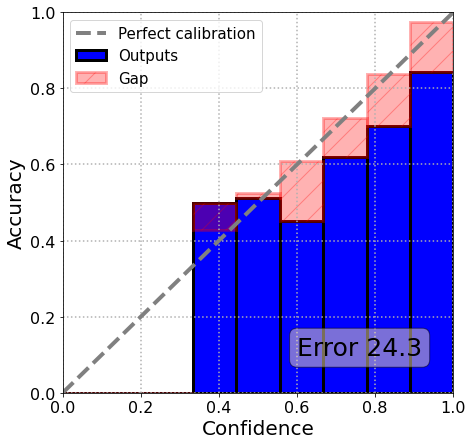

In [ ]:
# convert to int64 for later usage 
y_test = tf.cast(y_test, tf.int64)
# get the predicted labels
y_pred = tf.argmax(y_pred, -1)

# Discretize the confidence tensor:
# in order to use the Discretization layer of tf.keras we need to
# exclude the first and last element of the edge bins list in order to 
# compute the right interval 
layer = tf.keras.layers.Discretization(bin_boundaries=bins[1:-1])
binning = layer(confidence)  # binning[i] \in {0, ... ,8} for a total of 9 bins

# Initialize histogram array 
# .numpy() in order to update the value of the tensor
conf_bm = tf.zeros(num_bins-1).numpy()
acc_bm = tf.zeros(num_bins-1).numpy()
size_bm = tf.zeros(num_bins-1).numpy()

# For each bin we compute the desired score 
for b in range(num_bins-1):
  # select the sample corrisponding to that bin
  idx = tf.squeeze(tf.where(binning == b))
  if tf.size(idx) > 0:
    # compute the conf(bm)
    conf_bm[b] = tf.reduce_mean(tf.gather(confidence, idx))
    # compute the acc(bm)
    acc_bm[b] = tf.reduce_mean(tf.cast(tf.gather(y_test, idx) == tf.gather(y_pred,idx), tf.float32))


# Reliability diagram plot
with plt.rc_context(params_dict):
  plt.axis([0., 1., 0., 1.])
  # normalized probability density function
  bin_width = bins[1]-bins[0]
  plt.bar(bins[0:-1], acc_bm, width = bin_width, color = "blue", edgecolor = "black",
          align = "edge", linewidth = 3, label = "Outputs")
  plt.bar(bins[0:-1], conf_bm - acc_bm, bottom = acc_bm, width = bin_width, color = "red", align = "edge",
          alpha = 0.3, edgecolor = "red", linewidth = 3 , hatch='/', label = "Gap")
  plt.plot([0,1],[0,1], color = 'gray',  linestyle = "--", label = "Perfect calibration")
  # add params
  plt.grid(linestyle=':', linewidth=1.5)
  plt.ylabel("Accuracy")
  plt.xlabel("Confidence")
  plt.legend(fontsize = 15)

  # place a text box in upper left in axes coords
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  text =  "Error {:0.1f}".format((1-acc) * 100)
  plt.text(0.6, 0.15, text,  fontsize=25, verticalalignment='top', bbox=props)

  plt.show();

We can say that the model is not perfectly calibrated with room for improvement. 

In fact from the histogram of the confidence we have that the accuracy and average confidence don't overlap, having the model predict with high confidence the majority of the sample but indeed having lower accuracy missclassifying some sample.

While the Reliability diagram shows that the bins produce small / medium gap between confidence and accuracy. Since the model deviate from a perfect diagonal we can say its miscalibrated.

### Expected calibration error, ECE 


In [ ]:
size_bm = tf.math.bincount(binning.numpy(), minlength = num_bins-1, dtype = tf.float32)
ECE = tf.reduce_sum(tf.abs(acc_bm - conf_bm) * size_bm) / len(X_test)
print("The Expected Calibration Error (ECE) is: ", ECE.numpy())

The Expected Calibration Error (ECE) is:  0.12715735


###  Calibrating with the focal loss 

Following the paper: [Calibrating Deep Neural Networks using Focal Loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). 

The task of this exercise is to train again the neural network from before, using the Focal Loss (Section 4 in (Mukhoti et al., 2020)) instead of the cross-entropy:

\begin{equation}
L(y, \hat{y}) = - (1-\hat{y}_c)^\gamma \log \hat{y}_c
\end{equation}

where $\hat{y}$ is the vector of predictions from the network, $c$ is the index of the correct class ($y_c == 1$), $\gamma > 0$ is a hyper-parameter. For $\gamma=0$, this reduces to the cross-entropy.

In [ ]:
class FocalLoss(tf.keras.losses.Loss):
  
  def __init__(self, gamma):
    super().__init__()
    self.gamma = gamma

  def call(self, y_true, y_pred):
    """
    y_true: (n,1) true label tensor
    y_pred: (n,k) logit prediction tensor
    """
    # get the predicted probability corresponding to the true class
    y_c = tf.gather(tf.nn.softmax(y_pred, axis = 1), tf.cast(y_true, tf.int32), batch_dims=1, axis = 1)
    # we use directly the tf.keras implementation of the cross entropy loss to avoid numericaly instability
    cross_entropy  = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction="none")
    # L(y, y_hat) = (1-yc_hat)^gamma * CS    (oss: CS is already >> -log(yc_hat))
    loss = tf.math.pow((1-y_c), self.gamma) * cross_entropy(y_true, y_pred) # reduction is done automatically by tf
    return loss

In [ ]:
# Set seed for reproducibility
tf.keras.utils.set_random_seed(1234)
tf.random.set_seed(1234)

# Neural Network: 
net_cal = tf.keras.Sequential()
# first layer 
net_cal.add(tf.keras.layers.Dense(150))
net_cal.add(tf.keras.layers.BatchNormalization())
net_cal.add(tf.keras.layers.Activation('relu'))
# second layer
net_cal.add(tf.keras.layers.Dense(150))
net_cal.add(tf.keras.layers.BatchNormalization())
net_cal.add(tf.keras.layers.Activation('relu'))
# ouput layer (logit)
net_cal.add(tf.keras.layers.Dense(num_classes))

# Setup the training objects:
# initialize loss
focal_loss = FocalLoss(gamma = 4)  
# initialize metric
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
# initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

net_cal.compile(optimizer=optimizer, loss=focal_loss, metrics=accuracy)
 
history = net_cal.fit(
    x=X_train,
    y=y_train,
    batch_size=128,
    epochs=100,
    verbose=1)

Epoch 1/100
29/29 [==============================] - 2s 4ms/step - loss: 0.1094 - sparse_categorical_accuracy: 0.6668
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0537 - sparse_categorical_accuracy: 0.7272
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0459 - sparse_categorical_accuracy: 0.7452
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0417 - sparse_categorical_accuracy: 0.7547
Epoch 5/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0400 - sparse_categorical_accuracy: 0.7601
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.7683
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0342 - sparse_categorical_accuracy: 0.7879
Epoch 8/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0338 - sparse_categorical_accuracy: 0.7778
Epoch 9/100
29/29 [==============================] - 0s 

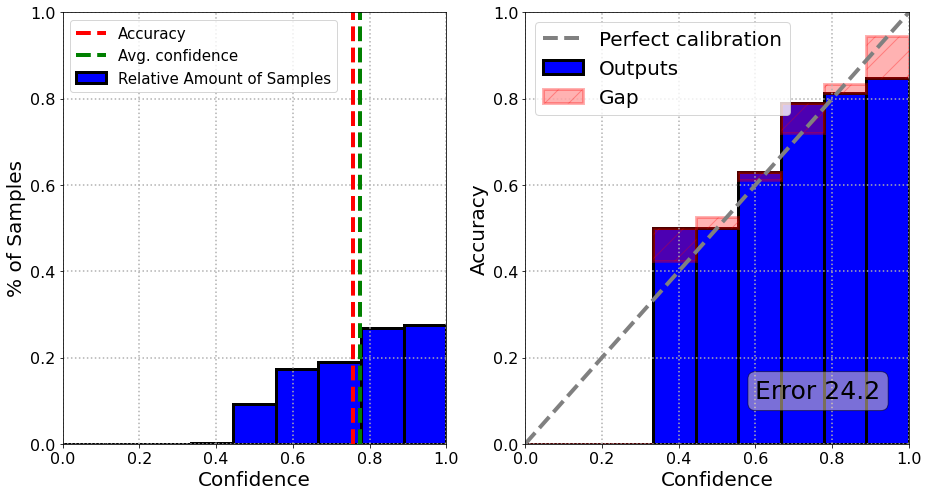



The ECE is:  0.051


In [ ]:
# setup
y_pred = net_cal.predict(X_test, verbose = 0)
y_test = tf.cast(y_test, tf.int64)
confidence = tf.reduce_max(tf.nn.softmax(logits = y_pred), axis = 1)
avg_conf = tf.reduce_mean(confidence)
_, acc = net_cal.evaluate(X_test, y_test, verbose = 0)

binning = layer(confidence) 
conf_bm = tf.zeros(num_bins-1).numpy()
acc_bm = tf.zeros(num_bins-1).numpy()

# For each bin we compute the desired score 
for b in range(num_bins-1):
  # select the sample corrisponding to that bin
  idx = tf.squeeze(tf.where(binning == b))
  if tf.size(idx) > 0:
    # compute the conf(bm)
    conf_bm[b] = tf.reduce_mean(tf.gather(confidence, idx))
    # compute the acc(bm)
    acc_bm[b] = tf.reduce_mean(tf.cast(tf.gather(y_test, idx) == tf.argmax(tf.gather(y_pred, idx), -1), tf.float32))

size_bm = tf.math.bincount(binning.numpy(), minlength = num_bins-1, dtype = tf.float32)
ECE = tf.reduce_sum(tf.abs(acc_bm - conf_bm) * size_bm) / len(X_test)


## ------------------------  Plot  ---------------------------
with plt.rc_context(params_dict):
  fig2, (ax1, ax2) = plt.subplots(1, 2, figsize = (13,7))
  bin_width = bins[1]-bins[0]

  # Confidence Histogram
  ax1.set_xlim((0., 1.))
  ax1.set_ylim((0., 1.))
  weights = tf.ones_like(confidence)/float(len(confidence))
  ax1.hist(x = confidence, bins = bins, weights = weights,  width = bin_width, 
          color = "blue", edgecolor = "black", linewidth = 3, label = "Relative Amount of Samples")
  ax1.axvline(x = acc, linestyle = "--", color = "red", label = "Accuracy")
  ax1.axvline(x = avg_conf, linestyle = "--", color = "green", label = "Avg. confidence")
  ax1.grid(linestyle=':', linewidth=1.5)
  ax1.set_ylabel("% of Samples")
  ax1.set_xlabel("Confidence")
  ax1.legend(fontsize = 15, loc = 'upper left');

  # Reliability Diagram
  ax2.set_xlim((0., 1.))
  ax2.set_ylim((0., 1.))

  ax2.bar(bins[0:-1], acc_bm, width = bin_width, color = "blue", edgecolor = "black",
          align = "edge", linewidth = 3, label = "Outputs")
  ax2.bar(bins[0:-1], conf_bm - acc_bm, bottom = acc_bm, width = bin_width, color = "red", align = "edge",
          alpha = 0.3, edgecolor = "red", linewidth = 3 , hatch='/', label = "Gap")
  ax2.plot([0,1],[0,1], color = 'gray',  linestyle = "--", label = "Perfect calibration")
  ax2.grid(linestyle=':', linewidth=1.5)
  ax2.set_ylabel("Accuracy")
  ax2.set_xlabel("Confidence")

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

  # place a text box in upper left in axes coords
  text =  "Error {:0.1f}".format((1-acc)*100)
  ax2.text(0.6, 0.15, text,  fontsize=25, verticalalignment='top', bbox=props)

  ax2.legend(fontsize = 20, loc = 'upper left')
  plt.tight_layout()
  plt.show();

print("\n")
print("The ECE is:  {:0.3f}".format(ECE))

From the above plot we can say that the model is now more calibrated.

Infact the average accuracy almost overlap the average confident.  While the reliability diagram reflect this overlap showing that the bins follow more precisly the perfect diagonal having smaller (sometimes almost zero) gaps. Indeed the accuracy follow the confident.
Also the ECE metrics is way lower than before.

### Conformal prediction 

Following paper: [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511). 

CP can be understood as an alternative approach to calibration to quantify uncertainty of a model. In CP we take a trained classifier $f(x)$, and we transform it to a set-classifier, i.e., a classifier that outputs a set $\mathcal{C}(x)$ of possible classes. The set is guaranteed to satisfy:

\begin{equation}
P(y \in \mathcal{C}(x)) \ge 1 - \alpha
\end{equation}

where $\alpha$ is a hyper-parameter called the **error rate**, i.e., the probability that the correct class is inside the set is $1-\alpha$. I implement a simple CP procedure which is described in Fig. 2 of (Angelopoulos and Bates, 2021).

In [ ]:
# Implement the CP procedure
import numpy as np  # for quantile only usage

alpha = 0.1
# 1: get conformal scores. 
n = y_test.shape[0]
cal_smx = tf.nn.softmax(net_cal.predict(X_test, verbose = 0), axis = 1)
cal_scores = 1-tf.gather(cal_smx, y_test, batch_dims=1, axis = 1)
# 2: get adjusted quantile
q_level = tf.math.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores, q_level, interpolation='higher')
# 3: form prediction sets
val_smx = tf.nn.softmax(net_cal.predict(X_test, verbose = 0), axis = 1).numpy()
prediction_sets = val_smx >= (1-qhat)

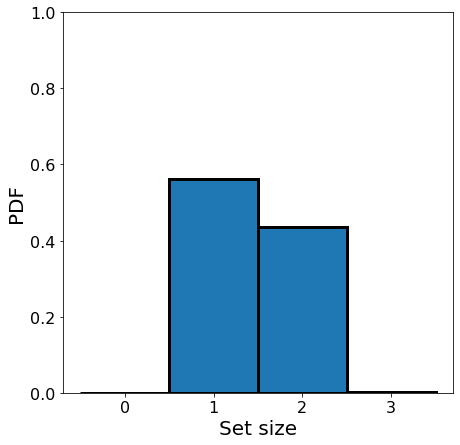

In [ ]:
# Plot a histogram of the size of the output set (e.g., check "Set size" on page 12 of (Angelopoulos and Bates, 2021)).
value = tf.math.bincount(tf.cast(tf.reduce_sum(tf.cast(prediction_sets, tf.float32), axis = 1), tf.int32), minlength = 4)
with plt.rc_context(params_dict):
  plt.bar([0., 1., 2., 3.], value / n, width = 1, align='center', edgecolor = "black", linewidth = 3)
  plt.xticks([0., 1., 2., 3.])
  plt.ylim(0,1)
  plt.xlabel("Set size")
  plt.ylabel("PDF");

### References

[1] Guo, C., Pleiss, G., Sun, Y. and Weinberger, K.Q., 2017. [On calibration of modern neural networks](https://arxiv.org/abs/1706.04599). In *ICML* (pp. 1321-1330). PMLR.

[2] Mukhoti, J., Kulharia, V., Sanyal, A., Golodetz, S., Torr, P. and Dokania, P., 2020. [Calibrating deep neural networks using focal loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). In *Advances in Neural Information Processing Systems*, 33, pp. 15288-15299.

[3] Angelopoulos, A.N. and Bates, S., 2021. [A gentle introduction to conformal prediction and distribution-free uncertainty quantification](https://arxiv.org/abs/2107.07511). *arXiv preprint arXiv:2107.07511*.